In [ ]:
%env WORKDIR=/tmp/vault
%env VAULT_K8S_NAMESPACE=vault
%env VAULT_HELM_RELEASE_NAME=vault
%env VAULT_SERVICE_NAME=vault-internal 
%env K8S_CLUSTER_NAME=cluster.local 

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

## https://developer.hashicorp.com/vault/docs/auth/approle
## https://developer.hashicorp.com/vault/tutorials/auth-methods/approle

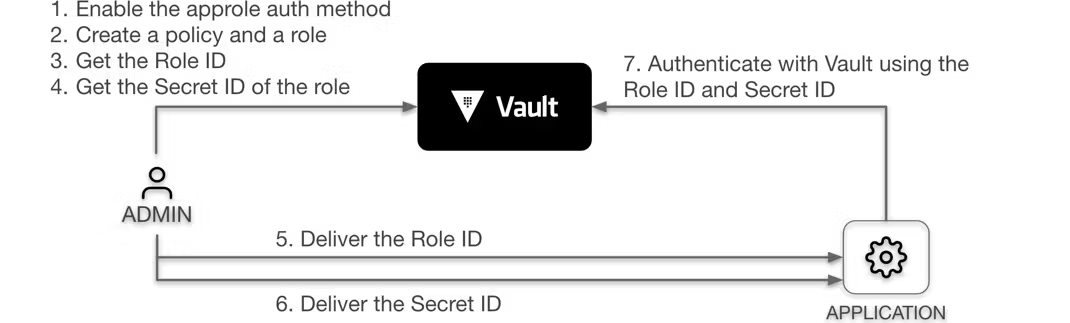

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.sAzkw4yobMxKGwKHYsDDRLia
%env VAULT_CACERT=/tmp/vault/vault.ca


In [ ]:
%%bash
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
EOF

vault secrets enable -path=kvv2 kv-v2

vault kv put kvv2/webapp/config username="static-user" password="static-password2"

In [ ]:
! vault auth enable approle

In [ ]:
%%bash
vault write auth/approle/role/my-role \
    secret_id_ttl=0 \
    token_num_uses=0 \
    token_max_ttl=0 \
    secret_id_num_uses=0 \
    token_policies=devk8s


In [ ]:
%%bash
vault read auth/approle/role/my-role
echo "****"
export ROLE_ID=$(vault read -format=json auth/approle/role/my-role/role-id | jq  .data.role_id)
echo "****"
export SECRET_ID=$(vault write -format=json -f auth/approle/role/my-role/secret-id | jq .data.secret_id)

echo "Obtaininig Vault token:"

cat > payload.json << EOF
{
  "role_id": $ROLE_ID,
  "secret_id": $SECRET_ID
}
EOF

export APP_TOKEN=$(curl -s -k --request POST --data @payload.json $VAULT_ADDR/v1/auth/approle/login | jq -r .auth.client_token)

echo "Obtaininig secret:"
curl -s -k --header "X-Vault-Token: $APP_TOKEN" --request GET $VAULT_ADDR/v1/kvv2/data/webapp/config
curl -s -k --header "X-Vault-Token: $APP_TOKEN" --request GET $VAULT_ADDR/v1/kvv2/data/webapp/config | jq -r .data


### Instalando el VSO usando helm

In [ ]:
%%bash
helm repo add hashicorp https://helm.releases.hashicorp.com
helm repo update hashicorp
helm install --namespace $VAULT_K8S_NAMESPACE vso hashicorp/vault-secrets-operator


In [ ]:
%%bash
## VaultConnection Custom Resource
# https://developer.hashicorp.com/vault/docs/platform/k8s/vso/sources/vault
cat > vso_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultConnection
metadata:
  namespace: vault
  name: example
spec:
  address: https://vault.vault.svc.cluster.local:8200
  skipTLSVerify: true

EOF
kubectl apply -f vso_crd.yaml
echo '---'
kubectl describe VaultConnection example -n vault


In [ ]:
! vault read -format=json auth/approle/role/my-role/role-id | jq -r .data.role_id
! vault write -format=json -f auth/approle/role/my-role/secret-id | jq -r .data.secret_id

In [ ]:
%%bash

export ROLE_ID=$(vault read -format=json auth/approle/role/my-role/role-id | jq -r .data.role_id)
export SECRET_ID=$(vault write -format=json -f auth/approle/role/my-role/secret-id | jq -r .data.secret_id)

kubectl delete secret secretid -n vault
kubectl create secret generic secretid -n vault --from-literal=id=$SECRET_ID

kubectl delete VaultAuth vault-auth-vaultns -n vault

cat > vaultauth_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultAuth
metadata:
  namespace: vault
  name: vault-auth-vaultns
spec:
  vaultConnectionRef: example
  method: appRole
  # Mount to use when authenticating to auth method.
  mount: approle
  allowedNamespaces: ["*"]
  appRole:
    roleId: $ROLE_ID
    secretRef: secretid

EOF

kubectl apply -f vaultauth_crd.yaml
echo '---'
kubectl describe VaultAuth vault-auth-vaultns -n vault

## CRD Static Secret

In [ ]:
%%bash
## Support KVv1 and KVv2

kubectl delete VaultStaticSecret vss1 -n vault

cat > secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: vault
  name: vss1
spec:
  vaultAuthRef: vault-auth-vaultns
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: vss1
EOF
kubectl apply -f secret.yaml
echo '---'
kubectl describe VaultStaticSecret vss1 -n vault
echo '---'
sleep 5
kubectl get secret vss1 -n vault -o yaml


In [ ]:
%%bash
## Support KVv1 and KVv2

export SECRET_ID=$(vault write -format=json -f auth/approle/role/my-role/secret-id | jq -r .data.secret_id)
kubectl delete secret secretid -n default
kubectl create secret generic secretid --from-literal=id=$SECRET_ID

kubectl delete VaultStaticSecret vss2 -n default

cat > secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: default
  name: vss2
spec:
  vaultAuthRef: vault/vault-auth-vaultns
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: vss2
EOF
kubectl apply -f secret.yaml
echo '---'
kubectl describe VaultStaticSecret vss2 -n default
echo '---'
sleep 5
kubectl get secret vss2 -n default -o yaml


In [ ]:
%%bash
## Support KVv1 and KVv2
kubectl delete ns test123
kubectl create ns test123

export SECRET_ID=$(vault write -format=json -f auth/approle/role/my-role/secret-id | jq -r .data.secret_id)

kubectl create secret generic secretid --from-literal=id=$SECRET_ID -n test123

cat > secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: test123
  name: vss3
spec:
  vaultAuthRef: vault/vault-auth-vaultns
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: vss3
EOF
kubectl apply -f secret.yaml
echo '---'
kubectl describe VaultStaticSecret vss3 -n test123
echo '---'
sleep 5
kubectl get secret vss3 -n test123 -o yaml


In [ ]:
%%bash
echo "namespace: Vault"
kubectl get secrets -A

In [ ]:
%%bash
vault kv put kvv2/webapp/config username="static-user2" password="static-password2"